**Определение возраста покупателей**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая сможет по фотографии определить возраст человека. Данная задача будет задачей регрессии, поэтому функцией потерь будет mean squared error, а метрикой оценки качества - mean absolute error. Результат работы модели на тестовой выборке не должен будет превышать 8.

Для решения поставленной задачи будут реализованы следующие этапы:

1. Исследовательский анализ данных (рассмотрение предоставленной выборки фотографий).
2. Обучение модели.
3. Анализ обученной модели
3. Заключение.

**1. Исследовательский анализ данных**

In [1]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
datagen = ImageDataGenerator(rescale=1./255)
df = pd.read_csv('/datasets/faces/labels.csv')
print(df.head())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


In [3]:
train = datagen.flow_from_dataframe(
    dataframe = df, directory = '/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345) 

Found 7591 validated image filenames.


In [4]:
features, target = next(train)
print(features.shape)
print(target.shape)

(32, 224, 224, 3)
(32,)


Строим график распределения возраста

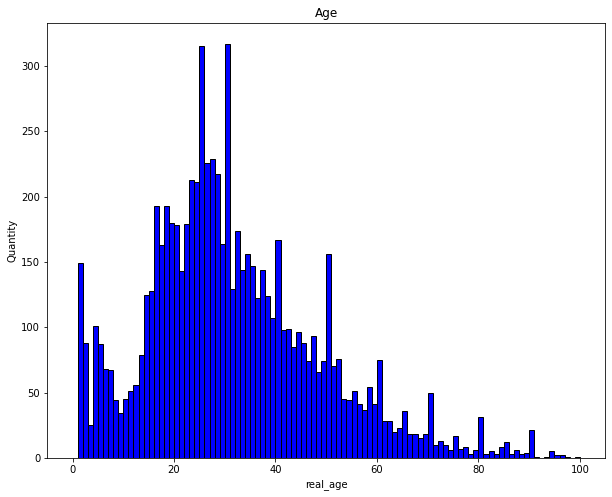

In [5]:
fig, ax = plt.subplots(figsize = (10,8))
plt.hist(df['real_age'], color = 'blue', edgecolor = 'black', bins=100, range = (0, 100))
plt.title('Age')
plt.xlabel('real_age')
plt.ylabel('Quantity');

Возраст в предоставленных данных колеблется от 1 до 100 лет.

Распечатаем 10 фотографий, чтобы посмотреть как выглядит датасет.

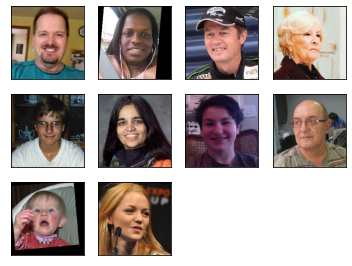

In [6]:
fig = plt.figure(figsize=(5, 5))
for i in range(10):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**2. Обучение модели**

In [7]:
def load_train(path):
    df = pd.read_csv(path + r'/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    train_datagen_flow = datagen.flow_from_dataframe(
                     dataframe = df,
                     directory = path + r'final_files',
                     x_col='file_name',
                     y_col='real_age',
                     target_size=(150, 150),
                     batch_size=32,
                     subset='training',
                     class_mode='raw',
                     seed=12345)
    return train_datagen_flow

In [8]:
def load_test(path):
    df = pd.read_csv(path + r'/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    val_datagen_flow = datagen.flow_from_dataframe(
                     dataframe = df,
                     directory = path + r'final_files',
                     x_col='file_name',
                     y_col='real_age',
                     target_size=(150, 150),
                     batch_size=32,
                     subset='validation',
                     class_mode='raw',
                     seed=12345)
    return val_datagen_flow

In [9]:
def create_model(input_shape):
    optimizer = Adam(lr=0.0009)
    backbone = ResNet50(input_shape=(150, 150, 3),
                    weights='imagenet',
                    include_top=False)  
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model


In [10]:
def train_model(model, train_datagen_flow, val_datagen_flow, batch_size=0, 
            epochs=8, steps_per_epoch=None, validation_steps=None):
    model.fit(train_datagen_flow, 
              validation_data=val_datagen_flow,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

In [ ]:
Train for 178 steps, validate for 60 steps
Epoch 1/8
2023-01-14 04:44:33.303262: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-14 04:44:33.584408: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 42s - loss: 216.2126 - mae: 11.1912 - val_loss: 549.1265 - val_mae: 18.3780
Epoch 2/8
178/178 - 34s - loss: 130.4982 - mae: 8.6993 - val_loss: 317.4295 - val_mae: 13.2011
Epoch 3/8
178/178 - 35s - loss: 97.2736 - mae: 7.5793 - val_loss: 436.9067 - val_mae: 15.8365
Epoch 4/8
178/178 - 34s - loss: 68.1223 - mae: 6.3903 - val_loss: 215.1369 - val_mae: 11.2096
Epoch 5/8
178/178 - 34s - loss: 44.6417 - mae: 5.1591 - val_loss: 127.8951 - val_mae: 8.5180
Epoch 6/8
178/178 - 34s - loss: 32.9080 - mae: 4.4481 - val_loss: 99.0015 - val_mae: 7.6334
Epoch 7/8
178/178 - 34s - loss: 22.3017 - mae: 3.6848 - val_loss: 158.5290 - val_mae: 9.5882
Epoch 8/8
178/178 - 34s - loss: 17.7989 - mae: 3.2623 - val_loss: 99.2621 - val_mae: 7.7933
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 99.2621 - mae: 7.7933
Test MAE: 7.7933

**3. Анализ обученной модели**

Для обучения модели использовали архитектуру Resnet50. На выходной слое оставили 1 нейрон, поскольку задача регрессии. Для вывода выбрали активацию Relu - положительные значения она выводит, а отрицательные приведет к 0. Из 7591 предоставленных изображений 25% выделили в тестовую выборку (1898 изображений), 75% - в обучающую (5693 изображения). разделили изображения в каждой выборке в батчи по 32 изображения. Итого при обучении модель прошла 178 шагов в обучающей выборке и 60 шагов в тестовой. Для достижения заданного уровня качества модели в настройках был выбран оптимайзер Адам со скоростью обучения LR = 0,0009. Уменьшение шага LR помогло улучшить качество модели. Также было подобрано количество epoch = 8.

**4. Заключение**

Была поставлена задача создать модель, которая сможет оценить возраст человека по фотографии. Были использованы данные с ChaLearn Looking at People, содержащие 7591 фотографию людей разных возрастов - от 0 до 100 лет. 50% фотографий - это изображения лиц от 20 до 40 лет. Для дальнейшей работы модели с фотографиями посетителей супермаркетов это немаловажно. Именно данная группа людей и является основными покупателями магазинов. В процессе обучения модели использовались разные параметры. Были найдены такие, при которых качество работы модели на тестовой выборке достигло 7,7933, что удовлетворяет требованиям заказчика. Модель с указанными параметрами рекомендуется к использованию.